In [ ]:
!pip install --user git+https://github.com/bolein/keras_img_iterator.git --upgrade

In [1]:
!pip install h5py --upgrade

Requirement already up-to-date: h5py in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s7f8-8b789a734450bf-e3f006c1cf76/.local/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.7 in /usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages (from h5py)
Requirement already up-to-date: six in /usr/local/src/bluemix_jupyter_bundle.v61/notebook/lib/python2.7/site-packages (from h5py)


In [ ]:
# !!! DO NOT READOWNLOAD EVERY TIME !!!
# Download the data (need only once!!)

## Load Libraries
import os
import requests, zipfile, io

# load data into platform
url = requests.get('https://he-s3.s3.amazonaws.com/media/hackathon/deep-learning-challenge-1/identify-the-objects/a0409a00-8-dataset_dp.zip')
data = zipfile.ZipFile(io.BytesIO(url.content))
data.extractall('data/')

In [2]:
# check if the files have been download in current directory
os.listdir('data')

['test_img', 'train_img', 'sample_submission.csv', 'train.csv', 'test.csv']

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

from keras.models import save_model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_img_iterator import SingleDirectoryIterator

from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
/gpfs/fs01/user/s7f8-8b789a734450bf-e3f006c1cf76/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


def convnet(num_classes, image_size):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(image_size, image_size, 3),
                     activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # the model so far outputs 3D feature maps (height, width, features)

    model.add(Flatten())  # this converts our 3D feature maps to 1D vectors
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [3]:
from io import StringIO
import requests
import json

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_storage_file(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': '***','domain': {'id': '63142f766d184081be8615180f60102c'},
            'password': '***'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

In [4]:
batch_size = 32
image_size = 128

meta_data = pd.read_csv('data/train.csv', header=0) 
# meta_data = pd.read_csv(get_storage_file('DefaultProjectbolein95gmailcom', 'train_sample.csv'), header=0)
filenames = meta_data['image_id'].apply(lambda id: id + '.png').values
labels = meta_data['label'].values
classes = list(set(labels))

# split into test and validation
files_train, files_validate, labels_train, labels_validate = \
    train_test_split(filenames, labels, test_size=0.2, random_state=42)

num_train_samples = files_train.shape[0]
num_val_samples = files_validate.shape[0]
num_classes = len(classes)

In [5]:
# this is the augmentation configuration we will use for training
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is a similar generator, for validation data
# only rescaling
test_gen = ImageDataGenerator(rescale=1. / 255)

train_iterator = SingleDirectoryIterator(
    directory='data/train_img/',
    filenames=files_train,
    labels=labels_train,
    classes=classes,
    image_data_generator=train_gen,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    seed=1337)

validation_iterator = SingleDirectoryIterator(
    directory='data/train_img/',
    filenames=files_validate,
    labels=labels_validate,
    classes=classes,
    image_data_generator=test_gen,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    seed=1337)

Found 2572 files belonging to 25 classes.
Found 643 files belonging to 25 classes.


In [6]:
# initialize and compile the model
model = convnet(num_classes, image_size)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
# Train the model
num_epochs = 30

validation_iterator.reset()
train_iterator.reset()

history = model.fit_generator(
    train_iterator,
    steps_per_epoch=num_train_samples // batch_size + 1,
    epochs=num_epochs,
    validation_data=validation_iterator,
    validation_steps=num_val_samples // batch_size + 1)

Epoch 1/30
80/80 [==============================] - 24s - loss: 3.2004 - acc: 0.0785 - val_loss: 3.1558 - val_acc: 0.1047
Epoch 2/30
80/80 [==============================] - 24s - loss: 3.1050 - acc: 0.0979 - val_loss: 3.0287 - val_acc: 0.1342
Epoch 3/30
80/80 [==============================] - 24s - loss: 3.0005 - acc: 0.1329 - val_loss: 2.9262 - val_acc: 0.1718
Epoch 4/30
80/80 [==============================] - 24s - loss: 2.9597 - acc: 0.1431 - val_loss: 2.8474 - val_acc: 0.1866
Epoch 5/30
80/80 [==============================] - 24s - loss: 2.8895 - acc: 0.1544 - val_loss: 2.8010 - val_acc: 0.1915
Epoch 6/30
80/80 [==============================] - 24s - loss: 2.8574 - acc: 0.1600 - val_loss: 2.7288 - val_acc: 0.2111
Epoch 7/30
80/80 [==============================] - 24s - loss: 2.7849 - acc: 0.1759 - val_loss: 2.6749 - val_acc: 0.2308
Epoch 8/30
80/80 [==============================] - 24s - loss: 2.7830 - acc: 0.1917 - val_loss: 2.6969 - val_acc: 0.2291
Epoch 9/30
80/80 [======

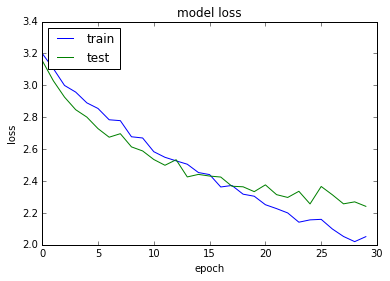

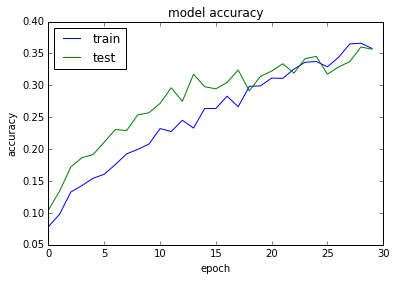

In [8]:
# Visualize learning
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
# Calculate f1-score against validation set

from sklearn.metrics import f1_score
from keras.utils import to_categorical

# Set up iterator for test set
metric_iterator = SingleDirectoryIterator(
    directory='data/train_img/',
    filenames=files_validate,
    image_data_generator=test_gen,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False)

predictions = model.predict_generator(
    generator=metric_iterator,
    steps=num_val_samples // batch_size + 1)

# binarize validation labels
encode = np.vectorize(lambda label: classes.index(label)) # encode to integers
y_true = to_categorical(encode(labels_validate), num_classes) # encode to one-hot vectors

int_labels = np.argmax(predictions, axis=1)
y_predicted = to_categorical(int_labels, num_classes)

score = f1_score(y_true, y_predicted, average='weighted')

print("model scored {} on validation set".format(score))

model scored 0.335940922609 on validation set


I see this product is coffee


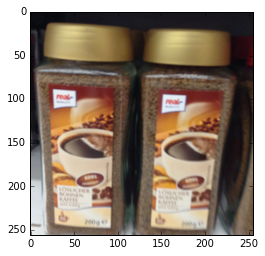

I see this product is candy


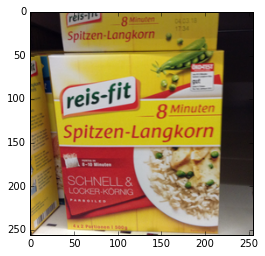

I see this product is pasta


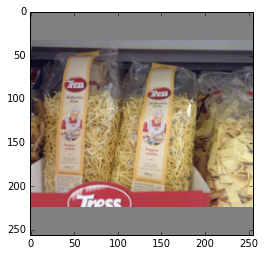

I see this product is tomatosauce


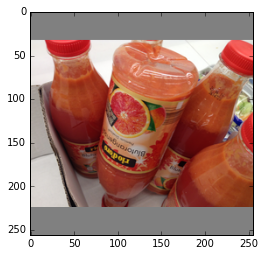

I see this product is pasta


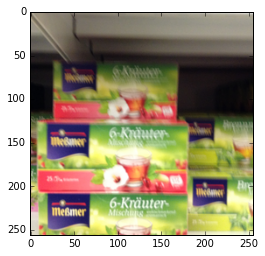

In [69]:
# top 5 predictions
from keras.preprocessing.image import load_img
for i in range(5):
    print('I see this product is ' + classes[int_labels[i]])
    plt.imshow(load_img('data/train_img/' + files_validate[i]))
    plt.show()

In [40]:
# Test model
# Read test data set
test_data = pd.read_csv('data/test.csv', header=0)
files_test = test_data['image_id'].apply(lambda id: id + '.png').values

In [41]:
# Set up iterator for test set
test_iterator = SingleDirectoryIterator(
    directory='data/test_img/',
    filenames=files_test,
    image_data_generator=test_gen,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False)

# make prediction
num_test_samples = files_test.shape[0]
predictions = model.predict_generator(
    generator=test_iterator,
    steps=num_test_samples // batch_size + 1)

test_labels = [classes[i] for i in np.argmax(predictions, axis=1)]

In [53]:
# function for downloading results
from IPython.display import HTML
import base64

def create_download_link(df, filename):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{filename}</a>'
    html = html.format(payload=payload,filename=filename)
    return HTML(html)

In [54]:
# save to file and create download link
submission = pd.DataFrame({'image_id':test_data.image_id, 'label':test_labels})
create_download_link(submission, "submission.csv")

In [68]:
# save model
model_file = 'model_{}.h5'.format(score)
save_model(model, model_file)
print('Training complete. model was saved as ', model_file)

('Training complete. model was saved as ', 'model_0.335940922609.h5')
